# Quality metrics for classification

## Confusion matrix

**TP** = true positive

**FP** = false positive

**TN** = true negative

**FN** = false negative

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange

cmap = mpl.colors.ListedColormap(['#992622', '#005AAA'])

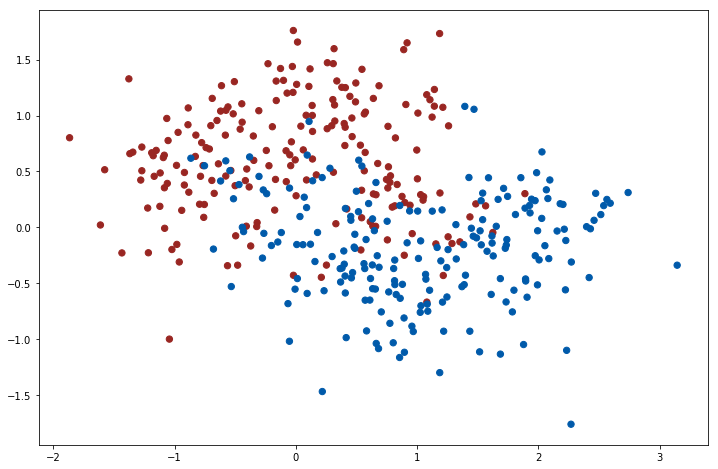

In [2]:
def gen_dataset(n_positive, n_negative):
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_negative))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_negative))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_positive))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_positive)) - .5

    X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                 np.append(outer_circ_y, inner_circ_y)]).T
    y = np.hstack([np.zeros(n_negative, dtype=np.intp),
                 np.ones(n_positive, dtype=np.intp)])

    X += np.random.normal(scale=0.4, size=X.shape)

    return X, y

X, y = gen_dataset(200, 200)
plt.figure(figsize=(12, 8))
plt.scatter(*X.T, c=y, s=40, cmap=cmap);

In [6]:
def plot_prediction(model, nx=100, ny=100, xmin=-2.5, xmax=3.5, ymin=-2.5, ymax=2.5):
    xx, yy = np.meshgrid(
      np.linspace(xmin, xmax, nx),
      np.linspace(ymin, ymax, ny)
    )

    preds = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0].reshape(xx.shape)
    plt.contour(xx, yy, preds, levels=[0.5], colors='k', linewidths=3)

## Exercise 1: plotting TP, FP, TN and FN

Modify the code below to distinguish true positives, false positives, true negatives and false negatives on the plot. Add legend.

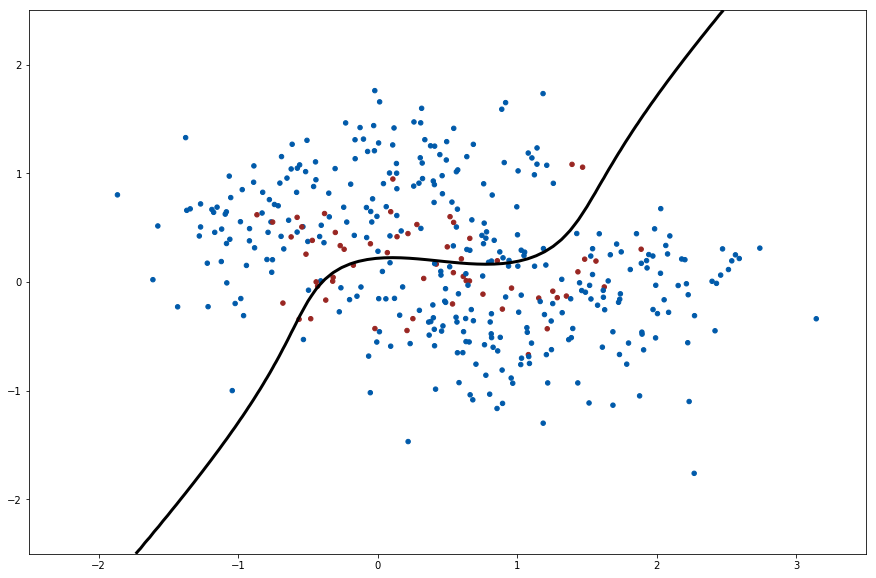

In [10]:
model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X, y)
preds = model.predict(X)

plt.figure(figsize=(15, 10))
plt.scatter(*X.T, c=np.array([y==preds]).ravel(), s=20, cmap=cmap);
plot_prediction(model)

## Exercise 2: accuracy, precision, recall, F1 score

$$\text{accuracy}=\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

$$\text{precision}=\frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$\text{recall}=\frac{\text{TP}}{\text{TP} + \text{FN}}$$

$$F_1=\frac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}}$$

Implement the calculation of quality metrics in the function below.

calculate_metrics(dummy_y_true, dummy_y_pred)

(skmetrics.accuracy_score(dummy_y_true, dummy_y_pred), skmetrics.precision_score(dummy_y_true, dummy_y_pred),
skmetrics.recall_score(dummy_y_true, dummy_y_pred), skmetrics.f1_score(dummy_y_true, dummy_y_pred))

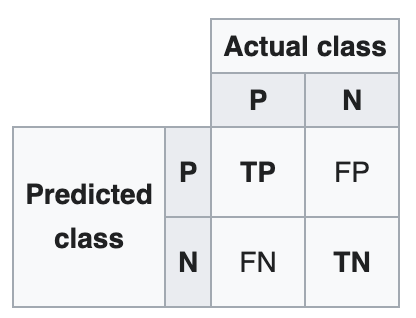

In [11]:
def calculate_metrics(y_true, y_pred):
    '''
    Function to calculate quality metrics.

    arguments:
    - y_true - numpy array of true labels (0 - negative class, 1 - positive class)
    - y_pred - numpy array of model predictions (0 - negative class, 1 - positive class)

    returns a tuple containing the calculated metrics:
    `(accuracy, precision, recall, f1)`
    '''
    TP = np.sum(y_true[y_true == 1] == y_pred[y_true == 1])
    TN = np.sum(y_true[y_true == 0] == y_pred[y_true == 0])
    FN = np.sum(y_true[y_pred == 0] != y_pred[y_pred == 0])
    FP = np.sum(y_true[y_pred == 1] != y_pred[y_pred == 1])

    # YOUR CODE: use only numpy operations to calculate the metrics
    accuracy = (TP + TN) * 1. / (TP + TN + FP + FN)
    precision = TP * 1. / (TP + FP)
    recall = TP * 1. / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    return [accuracy, precision, recall, f1]


# Automatic checks:
import sklearn.metrics as skmetrics

dummy_y_true = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
dummy_y_pred = np.array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

dummy_accuracy, dummy_precision, dummy_recall, dummy_f1 = \
  calculate_metrics(dummy_y_true, dummy_y_pred)
assert dummy_accuracy == skmetrics.accuracy_score(dummy_y_true, dummy_y_pred), 'Wrong accuracy'
assert dummy_precision == skmetrics.precision_score(dummy_y_true, dummy_y_pred), 'Wrong precision'
assert dummy_recall == skmetrics.recall_score(dummy_y_true, dummy_y_pred), 'Wrong recall'
assert dummy_f1 == skmetrics.f1_score(dummy_y_true, dummy_y_pred), 'Wrong F1 score'
print("All good!")

All good!


## Exercise 3: metrics as the function of class imbalance

Let's see how the metrics above behave when the classes are imbalanced.

For each $\alpha$ in `pos_class_fractions` below generate train and test datasets with $N = 50000$ points each, such that `n_positive`$ = \alpha N$, `n_negative`$ = (1 - \alpha)N$ (**don't foget to round and convert these numbers to integers!**). Train and evaluate the model on the generated data, plot test metrics (accuracy, precision, recall and F1) as a function of $\alpha$ on the same plot.

In [14]:
pos_class_fractions = np.linspace(0.01, 0.99, 30)

In [16]:
N = 50000
qual = []
qual_check = []
pos_class_fractions = np.linspace(0.01, 0.99, 30)
for alpha in pos_class_fractions:
    X_train, y_train = gen_dataset(int(N * alpha), int(N * (1 - alpha)))
    X_test, y_true = gen_dataset(int(N * alpha), int(N * (1 - alpha)))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    qual.append(calculate_metrics(y_true, y_pred))
    qual_check.append([skmetrics.accuracy_score(y_true, y_pred),
                       skmetrics.precision_score(y_true, y_pred),
                       skmetrics.recall_score(y_true, y_pred),
                       skmetrics.f1_score(y_true, y_pred)])

In [19]:
X_train, y_train = gen_dataset(500, 49500)
X_test, y_true = gen_dataset(500, 49500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
TP = np.sum(y_true[y_true == 1] == y_pred[y_true == 1])
TN = np.sum(y_true[y_true == 0] == y_pred[y_true == 0])
FN = np.sum(y_true[y_pred == 0] != y_pred[y_pred == 0])
FP = np.sum(y_true[y_pred == 1] != y_pred[y_pred == 1])

In [21]:
accuracy = (TP + TN) * 1. / (TP + TN + FP + FN)
precision = TP * 1. / (TP + FP)
recall = TP * 1. / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

In [22]:
recall, precision, f1, accuracy

(0.136, 0.6732673267326733, 0.22628951747088188, 0.9907)

In [23]:
X_train, y_train = gen_dataset(49500, 500)
X_test, y_true = gen_dataset(49500, 500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [24]:
TP = np.sum(y_true[y_true == 1] == y_pred[y_true == 1])
TN = np.sum(y_true[y_true == 0] == y_pred[y_true == 0])
FN = np.sum(y_true[y_pred == 0] != y_pred[y_pred == 0])
FP = np.sum(y_true[y_pred == 1] != y_pred[y_pred == 1])

In [25]:
accuracy = (TP + TN) * 1. / (TP + TN + FP + FN)
precision = TP * 1. / (TP + FP)
recall = TP * 1. / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

In [26]:
recall, precision, f1, accuracy

(0.9995353535353535, 0.9911258012820513, 0.9953128143230737, 0.99068)

In [27]:
qual = np.array(qual)

In [28]:
y_hat == y

NameError: name 'y_hat' is not defined

In [30]:
49500/50000.

0.99

In [ ]:
49500 объектов класса 1
500 объектов класса 0

Text(0,0.5,'metrics')

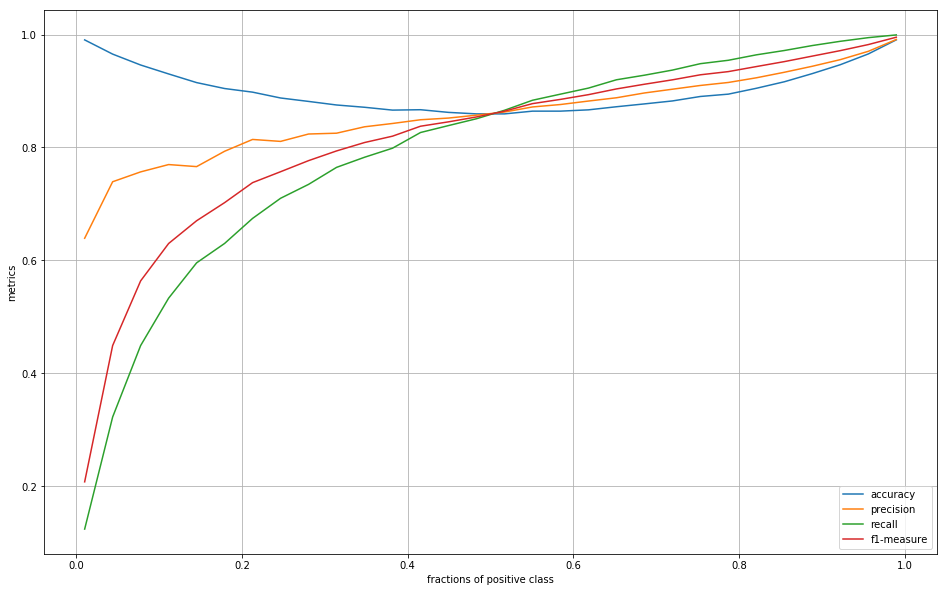

In [29]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(pos_class_fractions, qual[:, 0], label="accuracy")
plt.plot(pos_class_fractions, qual[:, 1], label="precision")
plt.plot(pos_class_fractions, qual[:, 2], label="recall")
plt.plot(pos_class_fractions, qual[:, 3], label="f1-measure")
plt.legend(loc='best')
plt.xlabel("fractions of positive class")
plt.ylabel("metrics")

## ROC curve

For a given model that gives the positive class score with $\hat{f}(x)$, prediction is obtained by thresholding this score with some threshold $T$:

$$\hat{y} = \mathbb{I}\left\{\hat{f}(x) \geq T\right\}$$

Then, true and false positive rates can be defined as functions of threshold.

True positive rate:
$$\text{TPR}(T) = \frac{\text{TP}(T)}{\text{TP}(T) + \text{FN}(T)}$$

False positive rate:
$$\text{FPR}(T) = \frac{\text{FP}(T)}{\text{FP}(T) + \text{TN}(T)}$$

ROC curve - TPR as a function of FPR.

Check out this nice demo: http://arogozhnikov.github.io/2015/10/05/roc-curve.html

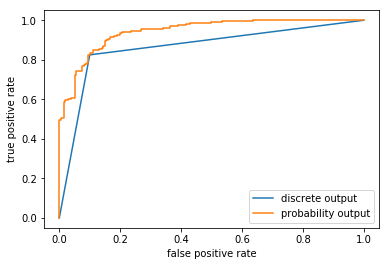

In [31]:
X_train, y_train = gen_dataset(200, 200)
X_test, y_test = gen_dataset(200, 200)

model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X_train, y_train)
preds_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, preds_test)
plt.plot(fpr, tpr, label='discrete output');
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label='probability output');
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate');

In [32]:
y_true = y_test
y_pred = preds_test

In [33]:
TP = np.sum(y_true[y_true == 1] == y_pred[y_true == 1])
TN = np.sum(y_true[y_true == 0] == y_pred[y_true == 0])
FN = np.sum(y_true[y_pred == 0] != y_pred[y_pred == 0])
FP = np.sum(y_true[y_pred == 1] != y_pred[y_pred == 1])

In [35]:
fpr, tpr, _ = roc_curve(y_test, preds_test)

In [36]:
fpr, tpr

(array([0. , 0.1, 1. ]), array([0.   , 0.825, 1.   ]))

In [37]:
FP * 1. / (FP + TN)

0.1

In [38]:
TP * 1. / (TP + FN)

0.825

Another metric - area under the ROC curve ("ROC AUC", or sometimes just "AUC").

 - AUC = 1.0 – perfect classification
 - AUC = 0.5 – random guess (worst classification)
 - AUC = 0.0 – perfect misclassification (converts to perfect classification by swapping the labels $1\leftrightarrow 0$)

In [40]:
from sklearn.metrics import roc_auc_score

print('AUC (discrete):', roc_auc_score(y_test, preds_test))
print('AUC (probability):', roc_auc_score(y_test, proba_test))

('AUC (discrete):', 0.8625)
('AUC (probability):', 0.9431)


# AUC

In [42]:
import pandas as pd

In [43]:
d = pd.DataFrame({"true": [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
                  "pred": [0.2, 0.7, 0.6, 0.1, 0.5, 0.3, 0.5, 0.4, 0.6, 0.1, 0.1, 0.9, 0.8, 0.1, 0.5, 0.3, 0.2]})

In [44]:
d

,pred,true
0,0.2,0
1,0.7,1
2,0.6,0
3,0.1,0
4,0.5,1
5,0.3,0
6,0.5,0
7,0.4,0
8,0.6,0
9,0.1,0


In [45]:
d = d.sort_values("pred", ascending=False)

In [46]:
d.values[:, 1].astype(int)

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [48]:
54.5/66

0.8257575757575758

In [49]:
roc_auc_score(d["true"], d["pred"])

0.8257575757575758

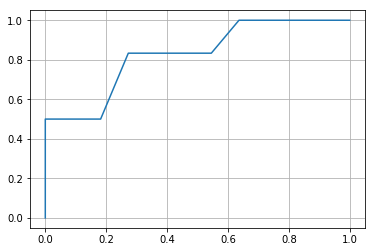

In [50]:
fpr, tpr, _ = roc_curve(d["true"], d["pred"])
plt.grid()
plt.plot(fpr, tpr, label='probability output');

In [ ]:
d

In [51]:
def I_a(a_i, a_j):
    if a_i > a_j:
        return 0.  
    elif a_i < a_j:
        return 1.
    return 0.5

def I_y(y_i, y_j):
    if y_i >= y_j:
        return 0.  
    return 1.

In [52]:
nominator = 0
denominator = 0
for i in range(d.shape[0]):
    for j in range(d.shape[0]):
        nominator += I_y(d["true"][i], d["true"][j]) * I_a(d["pred"][i], d["pred"][j])
        denominator += I_y(d["true"][i], d["true"][j])

In [53]:
nominator / denominator

0.8257575757575758